## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
# -------- SETTINGS --------
SEEDS = [42, 43, 44, 45, 46]
ALGORITHMS = ['cma_es','diferential_evolution', 'diferential_evolution_tuned', 'genetic_algorithm', 'random_search']
SCENARIOS = ['DownStepper-v0', 'ObstacleTraverser-v0']
CSV_FOLDER = '../results_controller'
METRIC = 'Best Fitness'  # The column we're analyzing
GENERATION_COL = 'Generation'
FONT_SIZE = 12
plt.rcParams.update({'font.size': FONT_SIZE})
fitness_values = {}

def load_data(algorithm, scenario):
    """
    Load all runs for a specific algorithm and scenario across different seeds
    Returns a list of DataFrames with added 'Seed' column
    """
    base_path = None
    # Handle special case for random_search
    if algorithm == 'random_search':
        base_path = os.path.join(CSV_FOLDER, 'random')
    elif algorithm == 'genetic_algorithm':
        base_path = os.path.join(CSV_FOLDER, 'ga')
    elif algorithm == 'cma_es':
        base_path = os.path.join(CSV_FOLDER, 'cma')
    elif algorithm == 'diferential_evolution':
        base_path = os.path.join(CSV_FOLDER, 'de')
    elif algorithm == 'diferential_evolution_tuned':
        base_path = os.path.join(CSV_FOLDER, 'de_tuned')
    
    if scenario == 'DownStepper-v0':
        scenario_path = os.path.join(base_path, 'down')
    elif scenario == 'ObstacleTraverser-v0':
        scenario_path = os.path.join(base_path, 'obstacle')
    
    dfs = []
    for seed in SEEDS:
        # Other algorithms follow standard pattern
        file_name = f"{algorithm}_{scenario}_seed_{seed}.csv"
        
        file_path = os.path.join(scenario_path, file_name)
        #print(f"Looking for: {file_path}")
        
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                df['Seed'] = seed
                df['Scenario'] = scenario
                dfs.append(df)
                #print(f"Successfully loaded {file_path}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        else:
            print(f"File not found: {file_path}")
    
    return dfs

def get_final_fitness(runs):
    """Extract final fitness values from all runs"""
    return [run[METRIC].iloc[-1] for run in runs]

def friedman_test(*samples):
    """Perform Friedman test with simplified output"""
    stat, p = stats.friedmanchisquare(*samples)
    print(f"\nFriedman Test: χ²={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant differences found (p < 0.05)")
    return stat, p

def plot_evolution(all_runs, scenario):
    """Plot fitness evolution with confidence intervals"""
    plt.figure(figsize=(10, 6))
    
    for algo, runs in all_runs.items():
        if not runs:
            continue
            
        # Calculate mean and std across runs
        gens = runs[0][GENERATION_COL]
        fitness = np.array([run[METRIC] for run in runs])
        mean = np.mean(fitness, axis=0)
        std = np.std(fitness, axis=0)
        
        plt.plot(gens, mean, label=algo.replace('_', ' '))
        plt.fill_between(gens, mean-std, mean+std, alpha=0.2)
    
    plt.title(f"Fitness Evolution ({scenario})")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"fitness_{scenario}.png", dpi=120)
    plt.show()

def main():
    # Load all data
    print("Loading data...")
    data = {
        algo: {
            scen: load_data(algo, scen) 
            for scen in SCENARIOS
        } 
        for algo in ALGORITHMS
    }

    # Analyze each scenario
    for scenario in SCENARIOS:
        print(f"\n===== Analyzing {scenario} =====")
        
        # Get final fitness values for all algorithms
        final_values = {
            algo: get_final_fitness(runs[scenario])
            for algo, runs in data.items()
            if runs[scenario]  # Only if we have data
        }
        
        # Print All values of each algorithm for the scenario and each run and store them in a dictionary
        print("\nAll fitness values:")
        for algo, values in final_values.items():
            fitness_values[algo] = values
            print(f"{algo:15}: {values}")
            
        
        # Perform Friedman test
        friedman_test(*final_values.values())
        
        # Plot evolution
        plot_evolution(
            {algo: data[algo][scenario] for algo in ALGORITHMS},
            scenario
        )
        
        # Show final values
        print("\nFinal fitness values:")
        for algo, values in final_values.items():
            print(f"{algo:15}: {np.mean(values):.3f} ± {np.std(values):.3f}")


Loading data...
File not found: ../results_controller\cma\obstacle\cma_es_ObstacleTraverser-v0_seed_42.csv
File not found: ../results_controller\cma\obstacle\cma_es_ObstacleTraverser-v0_seed_43.csv
File not found: ../results_controller\cma\obstacle\cma_es_ObstacleTraverser-v0_seed_44.csv
File not found: ../results_controller\cma\obstacle\cma_es_ObstacleTraverser-v0_seed_45.csv
File not found: ../results_controller\cma\obstacle\cma_es_ObstacleTraverser-v0_seed_46.csv
File not found: ../results_controller\de_tuned\down\diferential_evolution_tuned_DownStepper-v0_seed_42.csv
File not found: ../results_controller\de_tuned\down\diferential_evolution_tuned_DownStepper-v0_seed_43.csv
File not found: ../results_controller\de_tuned\down\diferential_evolution_tuned_DownStepper-v0_seed_44.csv
File not found: ../results_controller\de_tuned\down\diferential_evolution_tuned_DownStepper-v0_seed_45.csv
File not found: ../results_controller\de_tuned\down\diferential_evolution_tuned_DownStepper-v0_seed_4

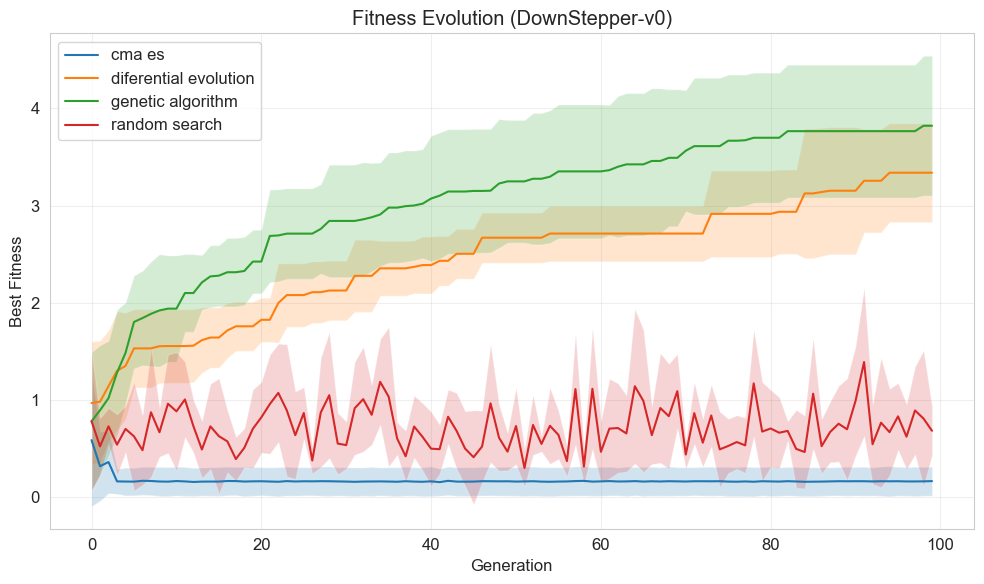


Final fitness values:
cma_es         : 0.162 ± 0.149
diferential_evolution: 3.338 ± 0.508
genetic_algorithm: 3.822 ± 0.720
random_search  : 0.681 ± 0.251

===== Analyzing ObstacleTraverser-v0 =====

All fitness values:
diferential_evolution: [1.5755319314833496, 1.8493486142813516, 1.8685991479649389, 1.625525680761334, 1.863729234497946]
diferential_evolution_tuned: [1.7907388443800305, 1.8010439108423026, 1.8547545884826409, 1.7652459331382582, 1.886844612108416]
genetic_algorithm: [2.4585325781059497, 1.8984629906192827, 1.738588443670828, 2.845540819917483, 2.084291644027548]
random_search  : [0.901296693611309, 0.8266358158148969, 0.8832512260266567, 1.2866977687054426, 0.8260808653607364]

Friedman Test: χ²=10.680, p=0.014
Significant differences found (p < 0.05)


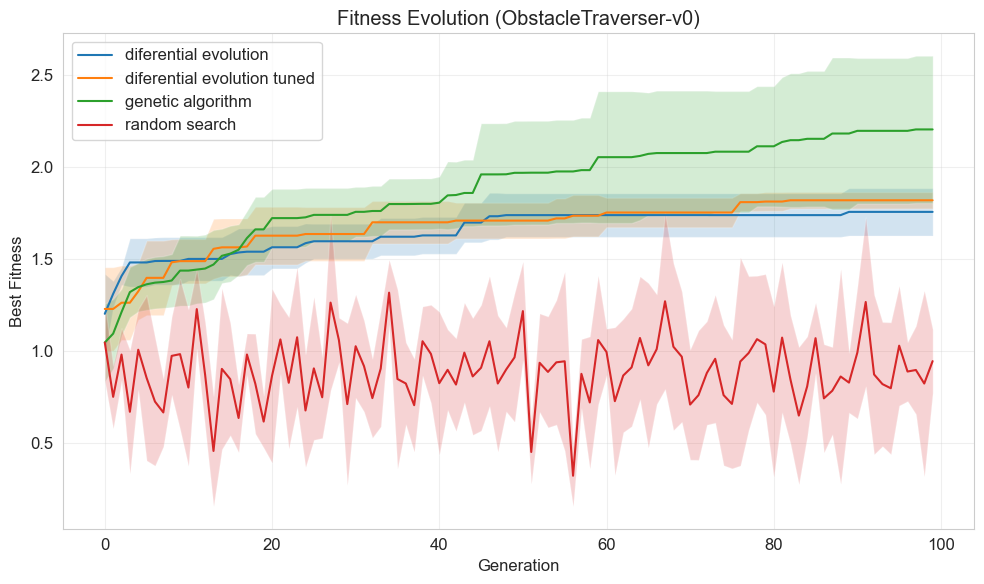


Final fitness values:
diferential_evolution: 1.757 ± 0.129
diferential_evolution_tuned: 1.820 ± 0.044
genetic_algorithm: 2.205 ± 0.400
random_search  : 0.945 ± 0.174


In [3]:

if __name__ == "__main__":
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 12
    main()

In [4]:
from itertools import combinations

def compare_algorithms(algorithm_results, alpha=0.05):
    """
    Compare all algorithm pairs using Wilcoxon signed-rank test
    with Bonferroni correction.
    
    Parameters:
    - algorithm_results: dict {algorithm_name: list_of_fitness_scores}
    - alpha: significance level (default 0.05)
    
    Returns:
    - List of significant comparisons with p-values
    """
    # Get all possible algorithm pairs to compare
    algorithms = list(algorithm_results.keys())
    pairs = list(combinations(algorithms, 2))
    
    # Bonferroni correction
    corrected_alpha = alpha / len(pairs)
    
    print(f"Comparing {len(algorithms)} algorithms ({len(pairs)} pairs)")
    print(f"Significance level: {alpha} (Bonferroni-corrected α = {corrected_alpha:.4f})")
    
    # Store significant results
    significant = []
    
    # Compare each pair
    for alg1, alg2 in pairs:
        # Get the fitness scores for this pair
        data1 = algorithm_results[alg1]
        data2 = algorithm_results[alg2]
        
        # Run Wilcoxon test
        stat, p = stats.wilcoxon(data1, data2)
        
        # Check significance
        is_significant = p < corrected_alpha
        if is_significant:
            significant.append((alg1, alg2, p))
        
        # Print all results (comment out if you only want significant ones)
        print(f"{alg1} vs {alg2}: p = {p:.4f} {'*' if is_significant else ''}")
    
    return significant

if __name__ == "__main__":
    # Your final fitness data (replace with actual data)
    
    # Run comparisons
    significant_pairs = compare_algorithms(fitness_values)
    
    # Print summary
    print("\nSignificant differences found:")
    for alg1, alg2, p in significant_pairs:
        print(f"- {alg1} vs {alg2}: p = {p:.4f}")

Comparing 5 algorithms (10 pairs)
Significance level: 0.05 (Bonferroni-corrected α = 0.0050)
cma_es vs diferential_evolution: p = 0.0625 
cma_es vs genetic_algorithm: p = 0.0625 
cma_es vs random_search: p = 0.0625 
cma_es vs diferential_evolution_tuned: p = 0.0625 
diferential_evolution vs genetic_algorithm: p = 0.1875 
diferential_evolution vs random_search: p = 0.0625 
diferential_evolution vs diferential_evolution_tuned: p = 0.4375 
genetic_algorithm vs random_search: p = 0.0625 
genetic_algorithm vs diferential_evolution_tuned: p = 0.1875 
random_search vs diferential_evolution_tuned: p = 0.0625 

Significant differences found:
